In [1]:
!pip install lmdb tqdm opencv-python gdown faiss-cpu Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 8.2 MB/s 


In [2]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-sr673ovs
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-sr673ovs
  Created wheel for timm: filename=timm-0.6.9-py3-none-any.whl size=510859 sha256=98d5a0d93dbb216beb46a502ed0e098dfc40139e90d71685bb295b3e92fdd7d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-eluiuyo8/wheels/a0/ec/5f/289118b747739bb1e02e36cf3d7e759721e881c183653719dc
Successfully built timm


In [3]:
!gdown --id 15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15OA8TMkAsEQ2fa0dCv59-mdGGBSE-KIJ
To: /content/archive_scenery.zip
100% 650M/650M [00:10<00:00, 60.1MB/s]


In [4]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive_scenery.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.3 s, sys: 1.12 s, total: 4.42 s
Wall time: 5.06 s


convert filenames to sequential ids

In [5]:
import os
n = 1
FILE_PATH="./scenery/"
from tqdm import tqdm
file_names = os.listdir(FILE_PATH)
file_names.sort()
for file_name in tqdm(file_names):
    oldext = os.path.splitext(file_name)[1]
    os.rename(FILE_PATH+file_name, FILE_PATH + str(n) + oldext)
    n += 1

100%|██████████| 4319/4319 [00:00<00:00, 28550.58it/s]


calculate global features, store in lmdb

In [6]:
import numpy as np
from os import listdir
from tqdm import tqdm
import lmdb
from PIL import Image
import torch
import timm
from torchvision import transforms


DB = lmdb.open('./features.lmdb',map_size=500*1_000_000) #500mb
IMAGE_PATH = "./scenery"


def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

def check_if_exists_by_id(id):
    with DB.begin(buffers=True) as txn:
        x = txn.get(int_to_bytes(id),default=False)
        if x:
            return True
        return False

device = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model('beit_base_patch16_224_in22k', pretrained=True)
model.head=torch.nn.Identity()
model.eval()
model.to(device)

_transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

def transform(im):
  desired_size = 224
  old_size = im.size  # old_size[0] is in (width, height) format
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  im = im.resize(new_size, Image.ANTIALIAS)
  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
  return _transform(new_im)

  
def get_features(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature_vector = model(image).cpu().numpy()[0]
    feature_vector/=np.linalg.norm(feature_vector)
    return feature_vector

def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img
    
def calc_nn_features(file_name):
    file_id = int(file_name[:file_name.index('.')])
    img_path = IMAGE_PATH+"/"+file_name
    try:
        query_image=read_img_file(img_path)
    except:
        print(f'error reading {img_path}')
        return None
    image_features = get_features(query_image)
    return (int_to_bytes(file_id), image_features.tobytes())


file_names = listdir(IMAGE_PATH)
print(f"images in {IMAGE_PATH} = {len(file_names)}")
new_images = []

for file_name in tqdm(file_names):
    file_id = int(file_name[:file_name.index('.')])
    if check_if_exists_by_id(file_id):
        continue
    new_images.append(file_name)

print(f"new images = {len(new_images)}")
new_images = [new_images[i:i + 100000] for i in range(0, len(new_images), 100000)]
for batch in new_images:
    features=[calc_nn_features(file_name) for file_name in tqdm(batch)]
    features = [i for i in features if i]  # remove None's
    print("pushing data to db")
    with DB.begin(write=True, buffers=True) as txn:
        with txn.cursor() as curs:
            curs.putmulti(features)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth" to /root/.cache/torch/hub/checkpoints/beit_base_patch16_224_pt22k_ft22k.pth


images in ./scenery = 4319


100%|██████████| 4319/4319 [00:00<00:00, 472845.89it/s]


new images = 4319


100%|██████████| 4319/4319 [03:01<00:00, 23.83it/s]

pushing data to db


learn PCA whitening

In [7]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import lmdb
dim = 768
pca = PCA(n_components=dim, whiten=True, copy=False)

DB_descriptors = lmdb.open("features.lmdb", readonly=True)
batch_size=DB_descriptors.stat()["entries"]
print(f"batch_size = {batch_size}")
features = np.zeros((batch_size, dim),np.float32)
def get_data():
    with DB_descriptors.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            retrieved = 0
            for data in tqdm(curs.iternext(keys=False, values=True),total=batch_size):
                if retrieved == batch_size:
                    return
                features[retrieved] = np.frombuffer(data,dtype=np.float32)
                retrieved+=1
get_data()
pca.fit(features)
with open('pca_w.pkl', 'wb') as handle:
    pickle.dump(pca, handle)

batch_size = 4319


100%|██████████| 4319/4319 [00:00<00:00, 397001.95it/s]


Add to index

In [8]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import lmdb
import faiss
import pickle 
DB_features = lmdb.open("features.lmdb", readonly=True)
dim = 768
faiss_dim = dim
quantizer = faiss.IndexFlat(faiss_dim, faiss.METRIC_L2)
index = faiss.IndexIDMap2(quantizer)
USE_PCA = True

def int_from_bytes(xbytes: bytes) -> int:
    return int.from_bytes(xbytes, 'big')


if USE_PCA:
    import pickle
    pca_w_file = Path("./pca_w.pkl")
    pca = None
    if pca_w_file.is_file():
        with open(pca_w_file, 'rb') as pickle_file:
            pca = pickle.load(pickle_file)
    if pca is None:
        print("no pca_w.pkl found. exiting...")
        exit()
    
def get_all_data_iterator(batch_size=10000):
    with DB_features.begin(buffers=True) as txn:
        with txn.cursor() as curs:
            temp_ids = np.zeros(batch_size,np.int64)
            temp_features = np.zeros((batch_size,dim),np.float32)
            retrieved = 0
            for data in curs.iternext(keys=True, values=True):
                temp_ids[retrieved] = int_from_bytes(data[0])
                temp_features[retrieved] = np.frombuffer(data[1],dtype=np.float32)
                retrieved+=1
                if retrieved == batch_size:
                    retrieved=0
                    if USE_PCA:
                        temp_features = pca.transform(temp_features)
                        for i in range(len(temp_features)):
                            temp_features[i]/=np.linalg.norm(temp_features[i])
                    yield temp_ids, temp_features
            if retrieved != 0:
                if USE_PCA:
                    temp_features = temp_features[:retrieved]
                    temp_features = pca.transform(temp_features)
                    for i in range(len(temp_features)):
                        temp_features[i]/=np.linalg.norm(temp_features[i])
                    yield temp_ids[:retrieved], temp_features
                else:
                    yield temp_ids[:retrieved], temp_features[:retrieved]

for ids, features in tqdm(get_all_data_iterator(100_000)):
    index.add_with_ids(features,ids)
faiss.write_index(index,"populated.index")

1it [00:00,  3.25it/s]


Search

In [9]:
def get_aqe_vector(feature_vector, n, alpha):
    _, I = index.search(feature_vector, n)
    top_features=[]
    for i in range(n):
        top_features.append(index.reconstruct(int(list(I[0])[i])).flatten())
    new_feature=[]
    for i in range(dim):
        _sum=0
        for j in range(n):
            _sum+=top_features[j][i] * np.dot(feature_vector, top_features[j].T)**alpha
        new_feature.append(_sum)

    new_feature=np.array(new_feature)
    new_feature/=np.linalg.norm(new_feature)
    new_feature=new_feature.astype(np.float32).reshape(1,-1)
    return new_feature

In [10]:
query_image = read_img_file(IMAGE_PATH+"/199.jpg")
query_features = get_features(query_image)
query_features = pca.transform(query_features.reshape(1,-1))
query_features[0]/=np.linalg.norm(query_features[0])
#query_features[0] = get_aqe_vector(query_features,5,0)

In [11]:
index = faiss.read_index("./populated.index")
D, I = index.search(query_features, 10)
# lims, D, I = index.range_search(query_features.reshape(1,-1), 1.6)

In [12]:
print("distances")
print(D)
print("indexes")
print(I)

distances
[[4.4640902e-11 1.0851781e+00 1.1797523e+00 1.5417231e+00 1.5762253e+00
  1.6032959e+00 1.6075277e+00 1.6849542e+00 1.6948053e+00 1.7004505e+00]]
indexes
[[ 199  626 1009 2804 4068 3457 1261 2885 2514 2227]]


In [13]:
from PIL import Image
images_np=[]
for image_id in I[0]:
  images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

# for image_id in I:
#   images_np.append(np.array(Image.open(f'{IMAGE_PATH}/{image_id}.jpg')))

In [14]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

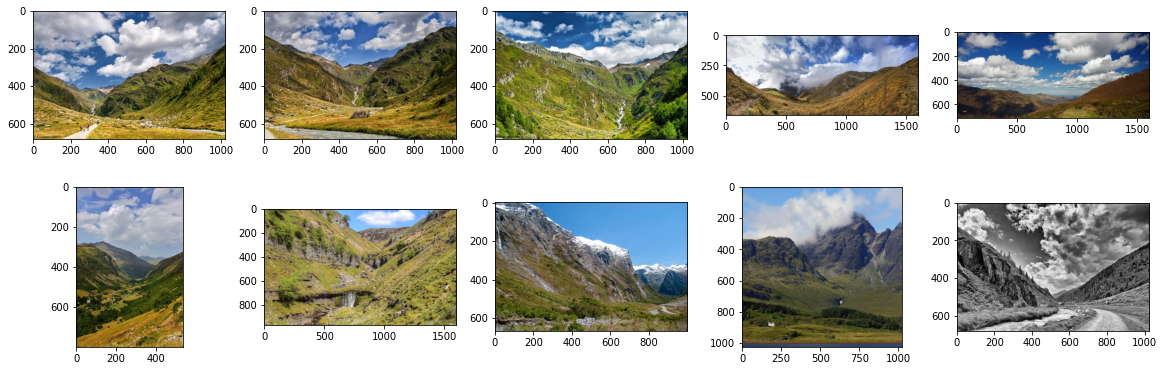

In [16]:
show_images(images_np)